In [1]:
import reporter.core.requester as req
import reporter.generator as gen
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

import csv
import re

%matplotlib inline

querys = {}

querys['licenseDistInd'] = "\
    SELECT \
        ?license \
        (count(?x) as ?count) \
        { \
            ?x okh:spdxLicense ?licenseUri . \
            { ?x okh:repoHost '%s'. } \
            BIND(REPLACE(STR(?licenseUri), 'https://spdx.org/licenses/', '') \
                AS ?license) \
        } \
    GROUP BY \
        ?license"

querys['licenseDistIndNew'] = "\
    SELECT \
        ?license \
        (count(?x) as ?count) \
        { \
            ?x okh:spdxLicense ?licenseUri . \
            BIND(REPLACE(STR(?licenseUri), 'https://spdx.org/licenses/', '') \
                AS ?license) \
        } \
    GROUP BY \
        ?license \
    ORDER BY \
        DESC(?count)"

querys['repoHosts'] = "\
    SELECT \
        ( \
            REPLACE( \
                REPLACE( \
                    REPLACE( \
                        STR(?repoHostFull), \
                        '^(www|certification|source|en)[.]', \
                        ''), \
                    '[.](com|org|wiki)$', \
                    ''), \
                '^field-ready-projects.openknowhow$', \
                'field-ready') \
            AS ?repoHost \
        ) \
        ?count \
        (round((?count / ?count_all) * 100) AS ?percent) \
    WHERE \
        { \
            { \
                SELECT ?repoHostFull (count(?px) AS ?count) \
                WHERE \
                    { \
                        ?px okh:repoHost ?repoHostFull \
                    } \
                GROUP BY ?repoHostFull \
            } \
            { \
                SELECT (count(?x) AS ?count_all) \
                WHERE \
                    { \
                        ?x okh:repoHost ?repoHostFull \
                    } \
            } \
        } \
    GROUP BY \
        ?count \
        ?count_all \
        ?repoHostFull"

querys['licensesReciprocality'] = "\
    SELECT \
        (count(?x) as ?count) \
        ?reType \
    WHERE \
        { \
            ?x okh:spdxLicense ?license ; \
            okh:spdxLicense ?id . \
            values (?id ?reType) \
            { \
                (<https://spdx.org/licenses/Apache-1.0> \"non\") \
                (<https://spdx.org/licenses/Apache-1.1> \"non\") \
                (<https://spdx.org/licenses/Apache-2.0> \"non\") \
                (<https://spdx.org/licenses/BSD-1-Clause> \"non\") \
                (<https://spdx.org/licenses/BSD-2-Clause> \"non\") \
                (<https://spdx.org/licenses/BSD-2-Clause-Paten> \"non\") \
                (<https://spdx.org/licenses/BSD-3-Clause> \"non\") \
                (<https://spdx.org/licenses/BSD-3-Clause-Clear> \"non\") \
                (<https://spdx.org/licenses/BSD-3-Clause-LBNL> \"non\") \
                (<https://spdx.org/licenses/BSD-4-Clause> \"non\") \
                (<https://spdx.org/licenses/MIT> \"non\") \
                (<https://spdx.org/licenses/MIT-0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-1.0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-2.0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-2.5> \"non\") \
                (<https://spdx.org/licenses/CC-BY-2.5-AU> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0-AT> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0-DE> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0-NL> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0-US> \"non\") \
                (<https://spdx.org/licenses/CC-BY-3.0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-4.0> \"non\") \
                (<https://spdx.org/licenses/CC-BY-SA-1.0> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-2.0> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-2.0-UK> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-2.1-JP> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-2.5> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-3.0> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-3.0-AT> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-3.0-DE> \"strong\") \
                (<https://spdx.org/licenses/CC-BY-SA-4.0> \"strong\") \
                (<https://spdx.org/licenses/CC0-1.0> \"non\") \
                (<https://spdx.org/licenses/CERN-OHL-1.1> \"strong\") \
                (<https://spdx.org/licenses/CERN-OHL-1.2> \"strong\") \
                (<https://spdx.org/licenses/CERN-OHL-P-2.0> \"non\") \
                (<https://spdx.org/licenses/CERN-OHL-S-2.0> \"strong\") \
                (<https://spdx.org/licenses/CERN-OHL-W-2.0> \"weak\") \
                (<https://spdx.org/licenses/GPL-1.0-only> \"strong\") \
                (<https://spdx.org/licenses/GPL-1.0-or-later> \"strong\") \
                (<https://spdx.org/licenses/GPL-2.0-only> \"strong\") \
                (<https://spdx.org/licenses/GPL-2.0-or-later> \"strong\") \
                (<https://spdx.org/licenses/GPL-3.0> \"strong\") \
                (<https://spdx.org/licenses/GPL-3.0-or-later> \"strong\") \
                (<https://spdx.org/licenses/SHL-0.5> \"non\") \
                (<https://spdx.org/licenses/SHL-0.51> \"non\") \
                (<https://spdx.org/licenses/SHL-2.0> \"non\") \
                (<https://spdx.org/licenses/SHL-2.1> \"non\") \
                (<https://spdx.org/licenses/TAPR-OHL-1.0> \"strong\") \
                (<https://spdx.org/licenses/N/A> \"N/A\") \
            } \
        } \
    GROUP BY \
        ?reType"

querys['projectInputMethod'] = "\
    SELECT \
        ?uploadMethod \
        (count(?x) AS ?count) \
    WHERE \
        { ?x okh:uploadMethod ?uploadMethod } \
    GROUP BY \
        ?uploadMethod"

querys['otrl'] = "\
    SELECT \
        (REPLACE(STR(?otrlUri), '^http://purl.org/oseg/ontologies/OTRL#', '') \
            AS ?otrl) \
        (count(?x) AS ?count) \
    WHERE \
        { ?x okh:technologyReadinessLevel ?otrlUri } \
    GROUP BY \
        ?otrlUri"

querys['odrl'] = "\
    SELECT \
        (REPLACE(STR(?odrlUri), '^http://purl.org/oseg/ontologies/OTRL#', '') \
            AS ?odrl) \
        (count(?x) AS ?count) \
    WHERE \
        { ?x okh:documentationReadinessLevel ?odrlUri } \
    GROUP BY \
        ?odrlUri"

querys['cpc'] = "\
    SELECT \
        ( \
            REPLACE( \
                STR(?cpc_full), \
                '^(.).+', \
                '$1') \
            AS ?cpc_main \
        ) \
        ( \
            REPLACE( \
                STR(?cpc_full), \
                '^.(.{0,2}).*', \
                '$1') \
            AS ?cpc_sub \
        ) \
        (count(?x) AS ?count) \
        (round((?count / ?count_all) * 100) AS ?percent) \
    WHERE \
        { ?x okh:cpcPatentClass ?cpc_full } \
    GROUP BY \
        ?cpc_main \
        ?cpc_short \
        ?cpc_full \
        ?count_all"

querys['countAll'] = "\
    SELECT \
        (count(?x) AS ?count) \
        { ?x rdf:type okh:Module }"

result_data = {}
for query_name, query in querys.items():
    results = req.request(query)
    result_data[query_name] = list(map(gen.map_result, results))
    
num_all_projects = result_data["countAll"][0]["count"]

def fetch_xy(x_selector="repoHosts.repoHost", y_selector="repoHosts.count"):
    fig_options = {}
    fig_options["x"] = x_selector
    fig_options["y"] = y_selector

    fig_options["x"] = fig_options["x"].split('.')
    fig_options["y"] = fig_options["y"].split('.')

    x_values = [d[fig_options["x"][1]] for d in result_data[fig_options["x"][0]]]
    y_values = [d[fig_options["y"][1]] for d in result_data[fig_options["y"][0]]]

    return x_values, y_values

def accum_below_abs(x_values, y_values, limit):
    accum = 0
    y_i = 0
    y_len = len(y)
    while y_i < y_len:
        if y_values[y_i] < limit:
            accum += y_values[y_i]
            x_values.pop(y_i)
            y_values.pop(y_i)
            # y_values = y_values[:y_i] + [sum(y_values[y_i:])]
            y_len -= 1
        else:
            y_i += 1

    if accum > 0:
        x_values = x_values + ['Misc.']
        y_values = y_values + [accum]

    return x_values, y_values

def accum_below_frac(x_values, y_values, limit_frac):
    y_total = float(sum(y_values))
    limit = int(limit_frac * y_total)
    return accum_below_abs(x_values, y_values, limit)

def remove_above_abs(x_values, y_values, limit):
    reftover_abs = 0
    total = 0
    y_i = 0
    y_len = len(y)
    while y_i < y_len:
        total += y_values[y_i]
        if y_values[y_i] >= limit:
            x_values.pop(y_i)
            y_values.pop(y_i)
            y_len -= 1
        else:
            reftover_abs += y_values[y_i]
            y_i += 1
    reftover_fraction = float(reftover_abs) / total

    return x_values, y_values, reftover_fraction

def remove_above_frac(x_values, y_values, limit_frac):
    y_total = float(sum(y_values))
    limit = int(limit_frac * y_total)
    return remove_above_abs(x_values, y_values, limit)

def piechart_create(x, y, title="repo-hosts", label="count", acc_frac=None, legend_vals=False, percent_multiplier=1.0):
    y_total = float(sum(y))
    
    if legend_vals:
        for y_i in range(len(y)):
            frac = y[y_i] / y_total
            x[y_i] = ('%4.1f%% (%8d) ' % (frac * 100 * percent_multiplier, y[y_i])) + x[y_i]

    plt.rcParams["figure.figsize"] = (10,3)
    plt.rcParams.update({'font.family': 'monospace'})

    fig, ax = plt.subplots()
    ax.pie(y,
        # autopct='%1.1f%%',
        pctdistance=1.14,
        radius = 0.8,
        wedgeprops = {'linewidth': 0.5, 'edgecolor':'k'}
        )
    sort_labels = True
    if sort_labels:
        label_ordering = sorted(range(len(y)), key=lambda k: y[k], reverse=True)
        x_ord = [ x[i] for i in label_ordering ]
    else:
        x_ord = x
    plt.legend(
        x_ord,
        bbox_to_anchor=(1,0),
        loc='lower right',
        bbox_transform=plt.gcf().transFigure)
    ax.set_title(title)
    fig.set_dpi(200)
    
    return fig, ax

def barchart_create(x, y, title="repo-hosts", label="count"):
    plt.rcParams["figure.figsize"] = (10,7)

    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(title, fontsize=12)
    plt.ylabel(label, fontsize=12)
    fig.set_dpi(200)
    
    return fig, ax

# function to add value labels
def barchart_add_labels(x, y, is_log = False):
    for i in range(len(x)):
        display_height = y[i]
        plt.text(i, display_height, y[i], ha = 'center', bbox = dict(facecolor = 'white', alpha = .5))

<!--
---
title: LOSH Data Report
subtitle: |
          | Annual, mostly statistical report on Open Source Hardware based on data from the LOSH knowledge base
          | **${PROJECT_VERSION_DATE}**
          | *version:* [${PROJECT_VERSION}](${PROJECT_VERSION_URL})
version: "${PROJECT_VERSION}"
date: "${PROJECT_VERSION_DATE}"
lang: en-US
charset: UTF-8
license: CC-BY-4.0
keywords:
- Open Source Hardware
- LOSH
- OSHdata
papersize: a4
geometry: "top=2cm,bottom=2cm,left=3cm,right=3cm"
comment: license applies to generated reports; date is automatically generated
...
-->

# Intro

## Welcome to our OSHdata report

Happy to see you here! You are reading the first report on data of the **Library of Open Source Hardware** (LOSH). LOSH is a distributed knowledge base for open source hardware (OSH) designs aiming to support design reuse, making OSH more explorable and its metadata available as Linked Open Data (LOD). LOD denotes openly available structured data which is interlinked with other data so it becomes more useful through semantic queries. This way of sharing information targets computers which can process the information automatically (rather than interpreting content written for human readers). Part of the vision of LOD is for the Internet to become a global database – and now OSH is part of it.

Our crawlers search different platforms for OSH, extract metadata about them and store them as LOD. The LOSH knowledge base thereby qualifies for 5 of 5 stars according to Tim Berners-Lee’s deployment scheme for open data (find more information [here](https://5stardata.info/)).\
You can explore the knowledge base through our frontend (which features a meta search engine for OSH): <https://losh.opennext.eu/>. All software modules, raw data and related documents are published under a free/open license – you can explore and improve all bits of this project or basically fork the whole system if you like.

This undertaking is based on the [Open Know-How initiative](http://www.internetofproduction.org/open-know-how) by the [Internet of Production alliance](http://www.internetofproduction.org/). We've been closely collaborating with the OSH community since the very beginning of LOSH. Our efforts partly merged with the [OSHdata project](oshdata.com), which published statistics based on data crawled from the [list of OSHWA-certified OSH projects](https://certification.oshwa.org/list.html). Since OSHWA published [its API](https://certificationapi.oshwa.org/documentation), no crawling is needed anymore. And since LOSH is here to collect data also from other platforms, we decided to take care of regular OSHdata reports – now also including data from other platforms. See the details of this handover in [this blogpost](https://oshdata.com/2021/07/27/new-oshdata-team/).

Generally, all data you will find here is also publicly available in the LOSH knowledge base. This report is generated using the [LOSH-Reporter](https://github.com/OPEN-NEXT/LOSH-Reporter/) tool ([GPL-3.0-or-later](https://raw.githubusercontent.com/OPEN-NEXT/LOSH-Reporter/main/LICENSE)). All we do is running a bunch of pre-defined queries on LOSH's knowledge base using that tool. If you want to look into the raw data yourself, e.g. to run some self-defined queries, find it [here](https://gitlab.opensourceecology.de/verein/projekte/losh-rdf) ([CC0-1.0](https://gitlab.opensourceecology.de/verein/projekte/losh-rdf/-/raw/main/LICENSE)). The report you are reading is licensed under the Creative Commons Attribution 4.0 International License ([CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/legalcode)). This license covers the entire report, including all text and graphics. OSHdata is a project of the [Open Hardware Observatory e.V. (non-profit)](https://en.oho.wiki/wiki/Imprint) since 2021 (before is was a project of Kenny Consulting Group, LLC).

## Get in contact with us

LOSH was started inside the EU-H2020-founded [OPEN_NEXT](https://opennext.eu/) project back in 2020 and is hosted and maintained by [Open Source Ecology Germany e.V. (non-profit)](https://ose-germany.de/) since 2022. You can reach these folks via eMail ([verein@ose-germany.de](mailto:verein@ose-germany.de?cc=martin.haeuer@ose-germany.de&subject=from%20the%20LOSH%20report)) or Telegram ([@OSEGWelcome](https://t.me/OSEGWelcome)) – don't be shy; looking forward to e-meet you :)

OSHdata is hosted by the [Open Hardware Repository e.V. (non-profit)](http://oho.wiki/) since 2021. Feel free to reach out to Robert Mies to get in touch: [rm@oho.wiki](mailto:rm@oho.wiki?cc=mh@oho.wiki&subject=from%20the%20LOSH%20report)

You can also sign up for our [newsletter](https://oshdata.com/newsletter/) or follow us on Twitter via [@OSHdata](https://twitter.com/OSHdata) or LinkedIn under [@OSHdata](https://www.linkedin.com/company/oshdata/).

# LOSH Data

## Introduction

Currently, LOSH collects data from the following platforms:

- [GitHub.com](http://github.com/)
- [Wikifactory.com](https://wikifactory.com/)
- [OSHWA Certification List](https://certification.oshwa.org/list.html)
- [Thingiverse.com](https://www.thingiverse.com/)

Additionally we have scripts catching data from:

- [Appropedia.org](https://appropedia.org/)
- [Open Know-How](https://openknowhow.org/) (including e.g. [Fieldready.org](https://www.fieldready.org/))

and making it available via GitHub. Furthermore we manually curated metadata for selected projects that we found during the research in the OPEN_NEXT project; it can be found [here](https://github.com/OPEN-NEXT/LOSH-list/). All data is published in raw form (original content, cleaned-up TOML manifest files and raw RDF) in a [dedicated repository](https://gitlab.opensourceecology.de/verein/projekte/losh-rdf/), so the whole knowledge base can be forked anytime.

The above mentioned online platforms have been chosen from a larger list considering:

- quality of OSH designs (effective reuse of OSH designs requires a complete technical documentation; certified content gives a good indication whether or not the technical documentation meets the criteria of DIN SPEC 3105),
- diversity of OSH designs (LOSH aims to offer a general purpose meta search for OSH designs, covering diverse technology fields),
- quality of metadata (as content quality, data quality differs a lot among OSH platforms; we want to showcase the potentials of rich metadata),
- technical limitations (the crawlers yet fully depend on the available platform APIs).

The minimum threshold for LOSH to be recognised as an OSH project is to have:

- a free/open license,
- a README file and
- at least one source file (other than the README.md, CONTRIBUTING.md or an image).

For deeper insights into the selection criteria or how data is collected, please refer to the D3.3 and D3.4 reports linked below.

We do not know how much of the actual OSH ecosystem we are covering by that – at least we can be sure that the content of the gathered projects is actually open source. For instance, in random samples we found that about 10\% of projects on Wikifactory.com and 60\% of projects on Thingiverse.com complied with the mentioned criteria (as shown in the D3.3 and D3.4 reports linked below).\
During the research of this project we could see how huge the OSH scene actually is. Our very, very rough and fully out-of-the-air estimation is that we covered around 20\% of all OSH designs published online. However, we do believe that not the bare number of projects is important, but their quality and impact. For a few good examples, please see the section of [highlighted projects](#highlighted-projects) at the end of this report.

If you are curious about the LOSH project and want more details e.g. to how data is collected you can find more information linked below:

- [some introductory slides](https://md.opensourceecology.de/p/nDpP9KbDs#/),
- the [OKH-LOSH metadata specification](https://github.com/OPEN-NEXT/OKH-LOSH/) containing all relevant definitions,
- the [D3.3 delivarable report](https://github.com/OPEN-NEXT/D3.3-Report) explainging the LOSH ecosystem,
- the [D3.4 deliverable report](https://github.com/OPEN-NEXT/D3.4-Report) explaining the data collection.

## Data Sources

### Current Data

By the publishing date of this report, the LOSH knowledge base contains:

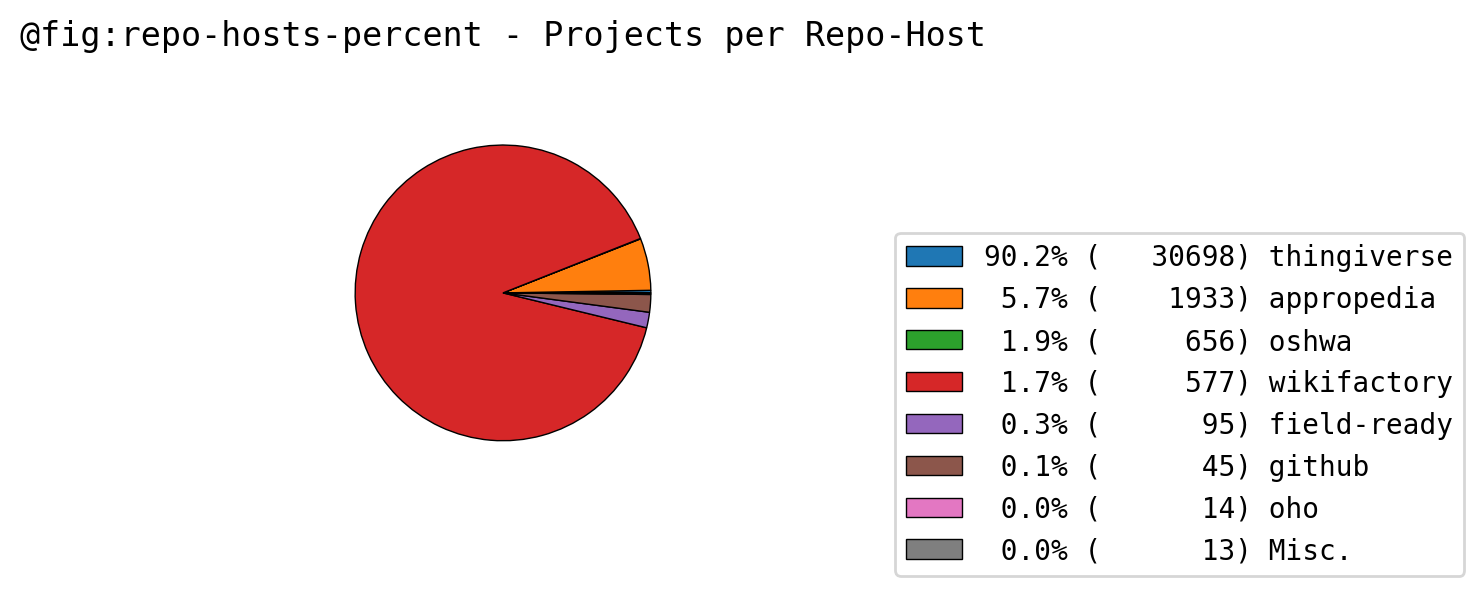

In [2]:
# We had such a table0-like list in the past, but it is much better and more easily visualized in the pie-chart below

# - {ghproj} from [GitHub.com](http://github.com/) (not counting Open Know-How or Appropedia.org) ({} % of all its projects)
# - {gltotalproj} from gitlab-based platforms ({} % of all its projects) <!---NOTE: gitlab-based repo hosts are listed in specs/gitlab-platforms.csv -->
# - {wifproj} from [Wikifactory.com](https://wikifactory.com/) ({} % of all its projects)
# - {oshwaproj} from [OSHWA Certification List](https://certification.oshwa.org/list.html) ({} % of all its projects)
# - {thingiproj} from [Thingiverse.com](https://www.thingiverse.com/) ({} % of all its projects)
# - {approproj} from [Appropedia.org](https://appropedia.org/) ({} % of all its projects)
# - {okhproj} from [Open Know-How](https://openknowhow.org/) ({} % of all its projects)
# - {otherproj} from diverse other sources ({} % of all its projects)

# templater.get_value(repoHosts,{"repoHost": "github.com"}, "count")} from [GitHub.com](http://github.com/) (not counting Open Know-How or Appropedia.org) (${get_value(repoHosts, {"repoHost": "github.com"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "gitlab.com"}, "count")} from [GitLab.com](http://gitlab.com/) (not counting Open Know-How or Appropedia.org) (${get_value(repoHosts, {"repoHost": "gitlab.com"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "source.mnt.re"}, "count")} from [source.mnt.re](https://source.mnt.re) (${get_value(repoHosts, {"repoHost": "source.mnt.re"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "wikifactory.com"}, "count")} from [Wikifactory.com](https://wikifactory.com/) (${get_value(repoHosts, {"repoHost": "wikifactory.com"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "certification.oshwa.org"}, "count")} from [OSHWA Certification List](https://certification.oshwa.org/list.html) (${get_value(repoHosts, {"repoHost": "certification.oshwa.org"}, "percent")} % of all its projects)
# - ${get_value(repoHosts,{"repoHost": "en.oho.wiki"}, "count")} from [Open Hardware Observatory](https://en.oho.wiki) (${get_value(repoHosts, {"repoHost": "en.oho.wiki"}, "percent")} % of all its projects)
# - ${get_value(repoHosts, {"repoHost": "www.thingiverse.com"}, "count")} from [Thingiverse.com](https://www.thingiverse.com/) (${get_value(repoHosts, {"repoHost": "www.thingiverse.com"}, "percent")} % of all its projects)

x_selector="repoHosts.repoHost"
y_selector="repoHosts.count"
acc = 5
x, y = fetch_xy(x_selector, y_selector)
x, y = accum_below_abs(x, y, acc)
fig_01, ax_01 = piechart_create(
    x,
    y,
    title="@fig:repo-hosts-percent - Projects per Repo-Host",
    label="repo-host",
    legend_vals=True)

<!--
…as illustrated in @fig:data-input-count, totalling data from our platforms.
According to how LOSH works, this equals {{data_source_count}} different data sources.
-->

<!-- ??? NOTE: the list there is, what from here on is abbreviated as {platforms} ??? -->

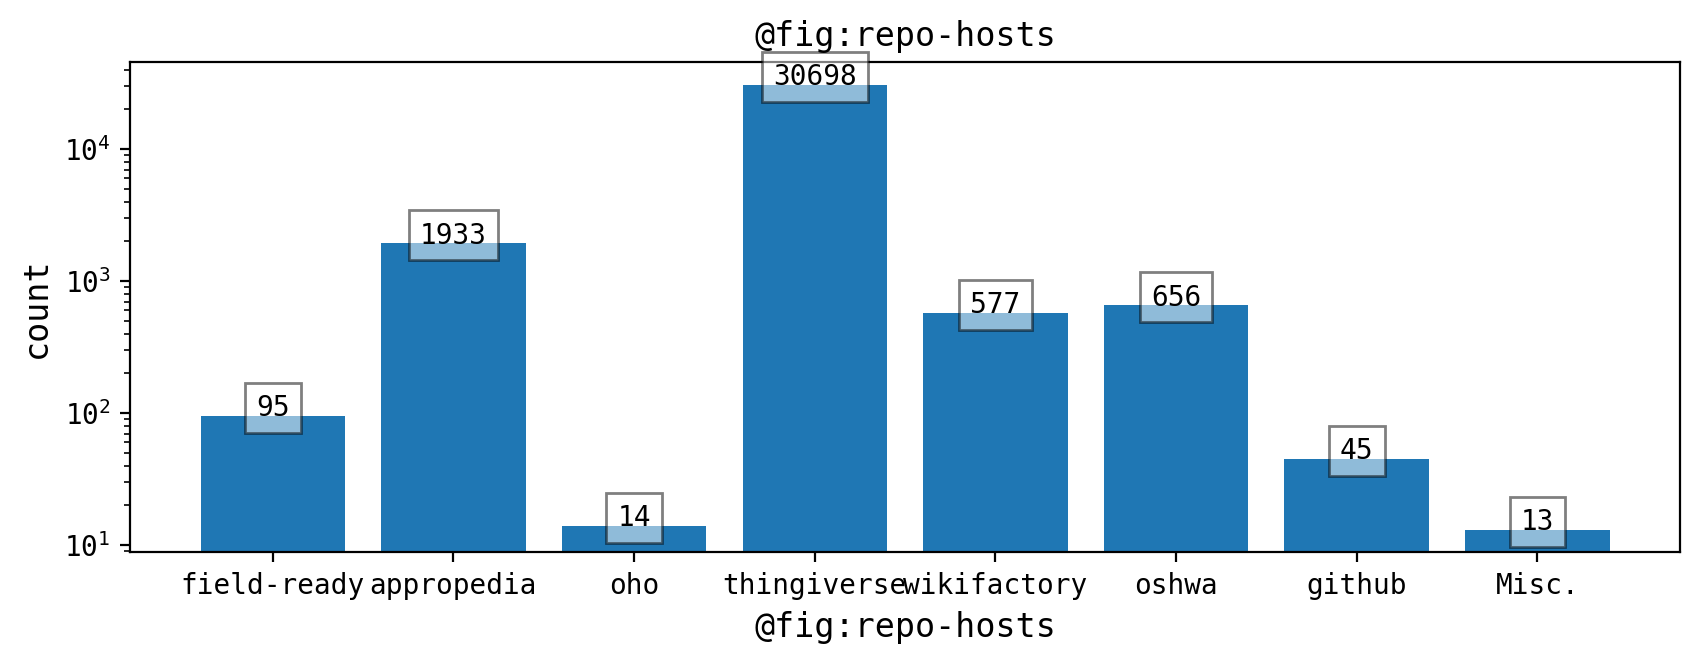

In [3]:
# a bar chart with the above mentioned values, each bar splitting into accepted and rejected projects (rejected projects on top)
x_selector="repoHosts.repoHost"
y_selector="repoHosts.count"
acc = 5
x, y = fetch_xy(x_selector, y_selector)
x, y = accum_below_abs(x, y, acc)
fig, ax = barchart_create(x, y, title="@fig:repo-hosts", label="count")
ax.set_yscale('log')
barchart_add_labels(x, y)

The corresponding metadata field for these graphs is `repo-host` and indicates, where the content of the OSH design is hosted (not necessarily where the metadata is found).

In this way, a total of 34,030 open hardware projects from different platforms were sampled. The lion's share of the sample, in fact more than 90\% of the projects (30,698), has been collected from the platform Thingiverse. With a share of 5.7\% and 1932 projects, Appropedia is the second largest source of open hardware projects in the sample. It is followed by the OSHWA platform and Wikifactory, each with just under 2\% of the projects. 

The very strong imbalance in the distribution of project sources in the sample can be explained by the orientation of the hosting platforms towards very different types of hardware projects. Thingiverse is very much focused on electronics and 3D printing and hosts a lot of small-scale and simple object designs from a huge decentralised community. Appropedia, on the other hand, is hosted by a rather small sustainability-minded community that documents somewhat more complex projects, mainly in the fields of renewable energy and appropriate of frugal technologies. The OSHWA database includes more mature projects with market potential mainly in the electronics sector, mostly registered by small companies and more professional developer groups. Wikifactory, on the other hand, covers a very broad spectrum of technologies from a very large and diverse community that usually documents its projects in an elaborate way for non-experts.

When interpreting the following analysis results, it is therefore important to consider the proportions in which the respective types of open hardware projects are represented in the sample. If it makes sense and is possible, we will break down the results for the largest platforms.

@fig:input-method-dist shows the distribution of upload methods that have been used for this data set.

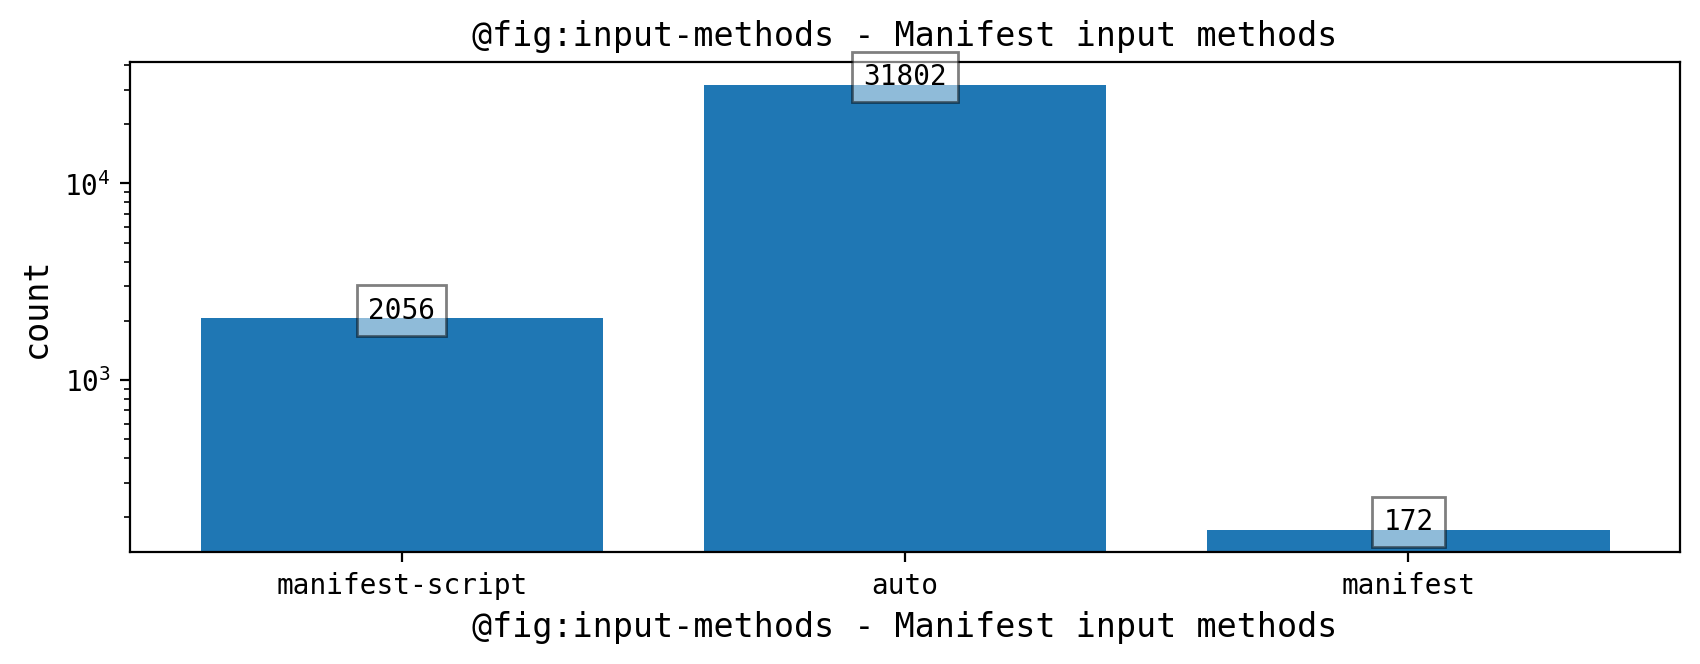

In [4]:
# bar chart showing the distribution of uploading methods used for LOSH (auto, manifest, manifest-script, manual)
x_selector="projectInputMethod.uploadMethod"
y_selector="projectInputMethod.count"
x, y = fetch_xy(x_selector, y_selector)
fig, ax = barchart_create(x, y, title="@fig:input-methods - Manifest input methods", label="count")
ax.set_yscale('log')
barchart_add_labels(x, y)

This data has been created by internal analyses of crawled data and is not reflected in any metadata field.

The clearly dominant upload method for metadata is `auto`, which refers to direct, automatic uploads through the platform's API. However, the `manifest-script` method, which refers to automaticly exectuded scripts that exctract metadata from platforms without suitable API, can be practically seen as an automatic method, too – developers of the corresponding OSH designs do not need to take any further steps to connect their designs to the LOSH knowledge base. Also no knowledge about the OKH-LOSH specification or its ontology is needed. In contrast, for the 172 manually created manifest files _is_ required so that the crawler can correctly parse the information.

This chart demonstrates to which extend data in the LOSH knowledge base currently depends on the platform's APIs. Currently, only manually created manifest files can comply with the full OKH-LOSH metadata specification, which is also due to its novelty as it was published during the OPEN_NEXT project.

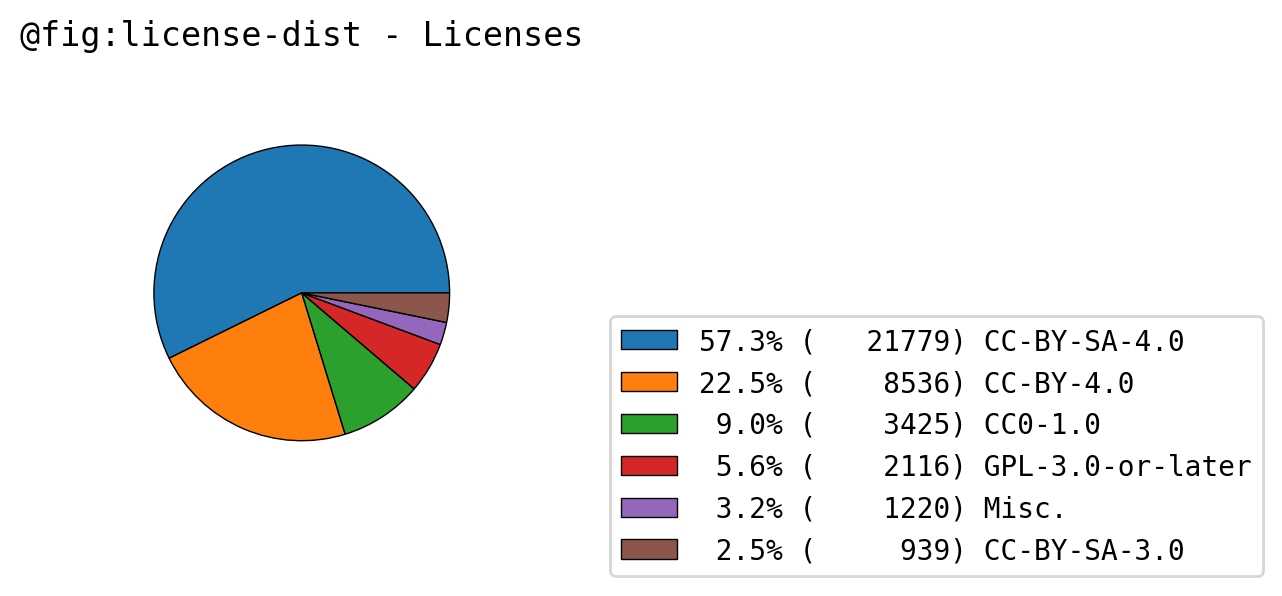

In [5]:
# pie chart showing the distribution of common `spdxLicense` values
x_selector="licenseDistIndNew.license"
y_selector="licenseDistIndNew.count"
acc_frac=0.01
x, y = fetch_xy(x_selector, y_selector)
x, y = accum_below_frac(x, y, acc_frac)
fig_03, ax_03 = piechart_create(
    x,
    y,
    title="@fig:license-dist - Licenses",
    label="license",
    legend_vals=True)

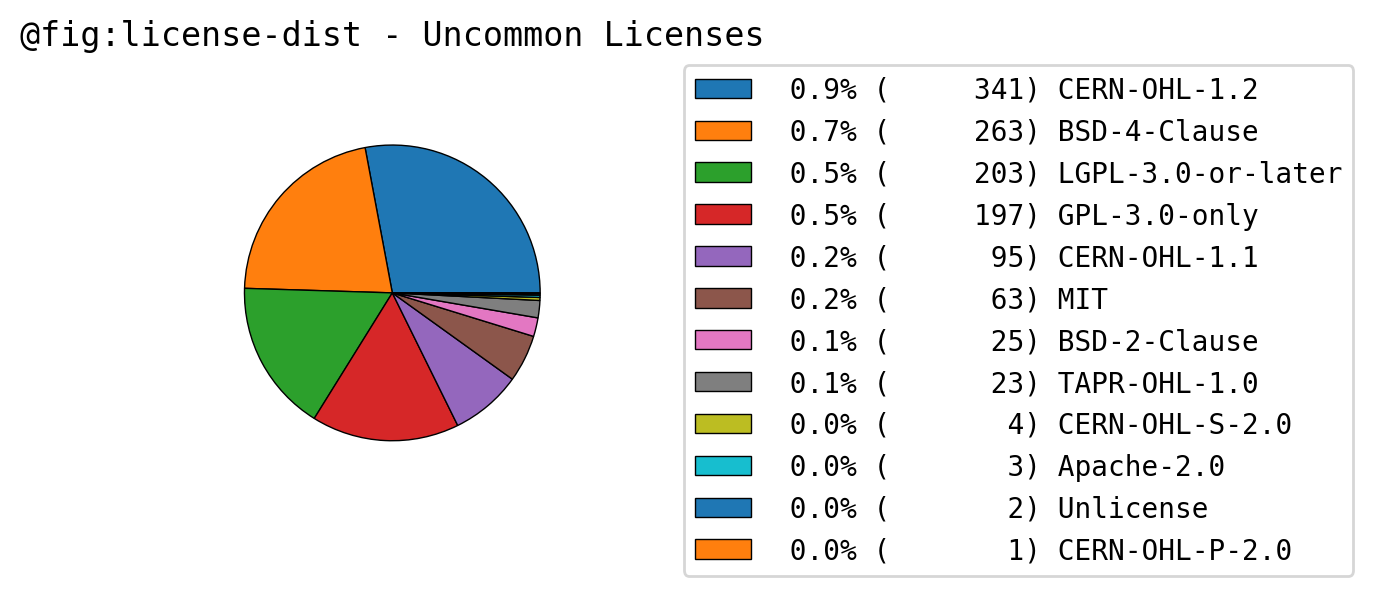

In [6]:
# pie chart showing the distribution of *not* common `spdxLicense` values
x_selector="licenseDistIndNew.license"
y_selector="licenseDistIndNew.count"
acc_frac=0.01
x, y = fetch_xy(x_selector, y_selector)
x, y, p_mult = remove_above_frac(x, y, acc_frac)
fig_04, ax_04 = piechart_create(
    x,
    y,
    title="@fig:license-dist - Uncommon Licenses",
    label="license-uncommon",
    legend_vals=True,
    percent_multiplier=p_mult)

<!--
optional chapter:

### Changelog

Since the first report, published back in February 2022, data input has developed as following:

TODO Robin (NO-CAN-DO: No registration-time data) combined historical line diagram of total count of projects per year & for each {platform}

Looking into the recent past @fig:data-hist-grow2 shows the grow rates for the past two years.

TODO Robin (NO-CAN-DO: No registration-time data) horizontal bar chart with grow rates per {platform} per each of the past 2 years + a bar for the total grow rate
{#fig:data-hist-grow2}
-->

## Licenses

In order to make hardware open source, its technical documentation must be publicly available for any use. Without diving into the legal details too much, these rights must be granted on several levels so that the hardware is _really_ open source. For the following graph we looked into the licenses under which the hardware designs have been published. If multiple licenses were used, we could only consider the license for the _hardware_ part (not e.g. licenses on separate parts of the technical documentation or related software) – this is a known limitation of this report (see section [Limitations](Limitations) below).

If you want to dive deeper in the legal aspects of open source hardware, check out the [OSH Guideline for Legal Issues](https://gitlab.com/OSEGermany/osh-guideline-legal-issues) published by [Open Source Ecology Germany e.V. (non-profit)](https://ose-germany.de/). There's also a tl;dr and some educational slides available on that matter.

The following @fig:license-dist shows the overall distribution of hardware licenses used by the projects in the LOSH knowledge base. The corresponding metadata field of the OKH-LOSH specification is `license`.

<!--
NOTE: We do not have this:
The following @fig:license-dist shows the distribution of licenses under which the _hardware_ has been published per platform.
-->

The Open Source Hardware Association (OSHWA) recommends seven licenses which follow their open source hardware definition: General Public Licenses (GPL) and Creative Commons (CC), CERN OHL, TAPR OHL, FreeBSD, MIT license, and the Creative Commons Attribution license. However, it has been argued that some don't apply well on hardware products (see e.g. [this argument in the CERN OHL FAQ about GPL](https://ohwr.org/project/cernohl/wikis/FAQ#q-why-not-use-existing-licences-such-as-gpl-and-any-in-the-family-of-creative-commons-licences)).

The vast majority, more than 90% of the projects, use CC licenses. Of these, about a tenth allow use without restrictions according to the most open CC license standard (CC0). About a quarter of the CC-licensed projects only require attribution (CC-BY). The most frequently used CC licenses, however, also require “share alike”, i.e. sharing under the same conditions (CC-BY-SA). Strongly reciprocal licenses (such as CC-BY-SA, GPL or CERN-OHL-S) require a further distrubion of the material under the same or compatible licenses. Consequently, when such material is remixed with other material, developers should keep an eye on the compatibility of licenses (e.g. CERN-OHL-S-2.0 appears to be incompatible with GPLv3, while CERN-OHL-1.2 still _is_ compatible with GPLv3 ([ref](https://ohwr.org/project/cernohl/wikis/FAQ#q-is-cern-ohl-s-compatible-with-gpl)).

The dominance of CC licenses is certainly due to their high profile among the general public. With a share of 5.6%, the GNU general public license version 3.0 (GPL-3.0) is the second most frequently used standards in the sample. Only a very small fraction of projects uses dedicated open hardware standards, such as those developed by CERN (CERN OHL) or TAPR (TAPR OHL).

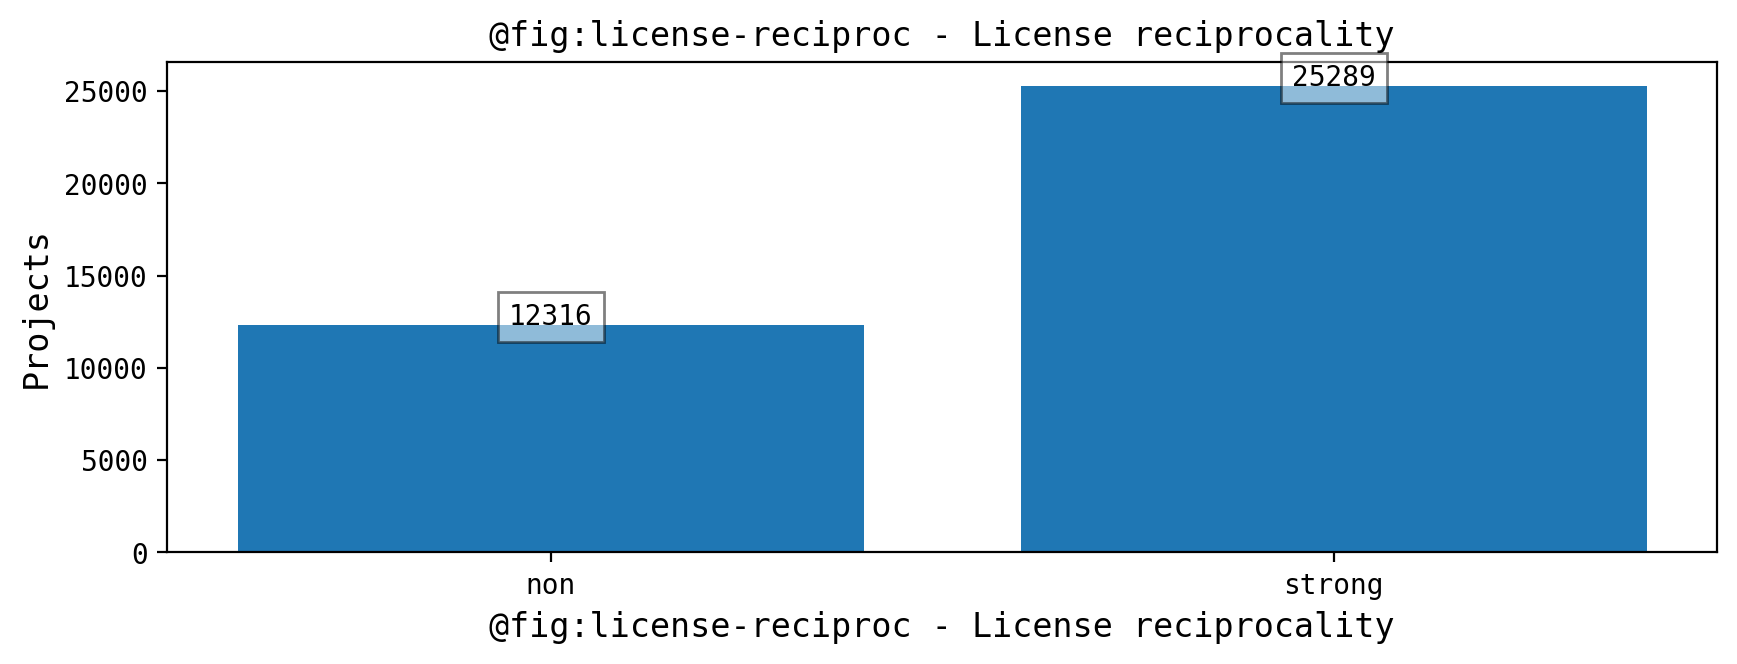

In [7]:
# pie chart showing the overall distribution of `spdxLicense`, sorted by strongly, weakly an non-reciprocal licensing schemes
x_selector="licensesReciprocality.reType"
y_selector="licensesReciprocality.count"
x, y = fetch_xy(x_selector, y_selector)
# fig, ax = barchart_create(x, y, title="reciprocality", label="overall distribution of spdxLicense")
fig, ax = barchart_create(x, y, title="@fig:license-reciproc - License reciprocality", label="Projects")
# ax.set_yscale('log')
barchart_add_labels(x, y)

As shown in the figure above, from 3 OSH projects approximately two use a strong reciprocal open source license ("strong copyleft", e.g. [CERN-OHL-S-2.0](https://ohwr.org/cern_ohl_s_v2.txt), [GPL-3.0](https://www.gnu.org/licenses/gpl-3.0.txt) or [CC-BY-SA-4.0](https://creativecommons.org/licenses/by-sa/4.0/legalcode)), one a "permissive" one ("non-copyleft", e.g. [CERN-OHL-P-2.0](https://ohwr.org/cern_ohl_p_v2.txt), [MIT](https://opensource.org/licenses/MIT) or [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/legalcode)). So-called "weak copyleft" (e.g. [CERN-OHL-W-2.0](https://ohwr.org/cern_ohl_w_v2.txt) or [LGPL-3.0](https://www.gnu.org/licenses/lgpl+gpl-3.0.txt)) licenses don't seem to be such a popular licensing since not a single design with that licensing scheme has been found in the current dataset.

This data has been created linking to the [SPDX knowledge base](https://spdx.org/rdf/terms/) and hence is not directly represented in any metadata field.

## Hardware Types

### Open Technology & Documentation Readiness

Open Technology and Documentation Readiness Levels (OTRL, ODRL, as defined in [ref](https://docs.google.com/document/d/1-l6DI91unnAshzjKhjotpAfy_8RsS-9T7YmdYuwL4RI/edit#)) give a good approximation:

1. how mature the hardware design itself is (OTRL) and
2. how mature and open the documentation is (ODRL).

The following table shows the different levels. For further details please refer to the respective publication: DOI: [10.1016/j.procir.2022.05.306](https://doi.org/10.1016/j.procir.2022.05.306)

**Open Technology Readiness Level (OTRL)**

| Level  | Short description                               | Main outcome                                               |
|--------|-------------------------------------------------|------------------------------------------------------------|
| OTRL-1 | Ideation / needs identification                 | Product idea, needs and initial specifications are defined |
| OTRL-2 | Conception / definition of product architecture | Mature product concept has been formulated                 |
| OTRL-3 | Design and modelling                            | Product model is developed                                 |
| OTRL-4 | Prototyping and testing                         | Full functional prototype is built and tested              |
| OTRL-5 | Manufacturing development                       | Fairly reliable processes identified and characterised     |
| OTRL-6 | Product qualification                           | Certificate marking conformity assessment or comparable    |

**Open Documentation Readiness Level (OTRL)**

| Level  | Short description                            | Main outcome                                                                                             |
|--------|----------------------------------------------|----------------------------------------------------------------------------------------------------------|
| ODRL-1 | Documentation process commenced              | Published information under free open source licence                                                     |
| ODRL-2 | Collaborative documentation in progress      | Provision of documentation files and in editable formats enabling asynchronous collaborative development |
| ODRL-3 | Full documentation published                 | Complete documentation as per DIN SPEC 3105-1                                                            |
| ODRL-4 | Full documentation for product qualification | Product qualification documents published enabling decentralised commercial distribution                 |

Both scales can be combined and levels can be verified by an independent party, the respective level can then marked with a star. For instance, the [OpenFlexure Microscope](https://openflexure.org/) (see [Highlighted projects](#highlighted-projects) below) has been attested as open source hardware in a community-based assessment process according to DIN SPEC 3105-2, it thus qualifies for `ODRL-3*`.

For illustration, two extreme combinations of the scales would be:

- an OSH design with OTRL-6 and ODRL-1,
  meaning a safe-to-use product that could be circulated on the market,
  but has barely any documentation published appart from a README,
  maybe a few STEP files and bearing a free/open license;
- an OSH design with OTRL-1 and ODRL-4,
  so a design still in the ideation phase,
  but exeptionally well-documented,
  even with documents for a (future) CE-Certification published under a free/open license.

Among the whole knowledge base,
the readiness levels distribute as shown in @fig:otrl-total and @fig:odrl-total

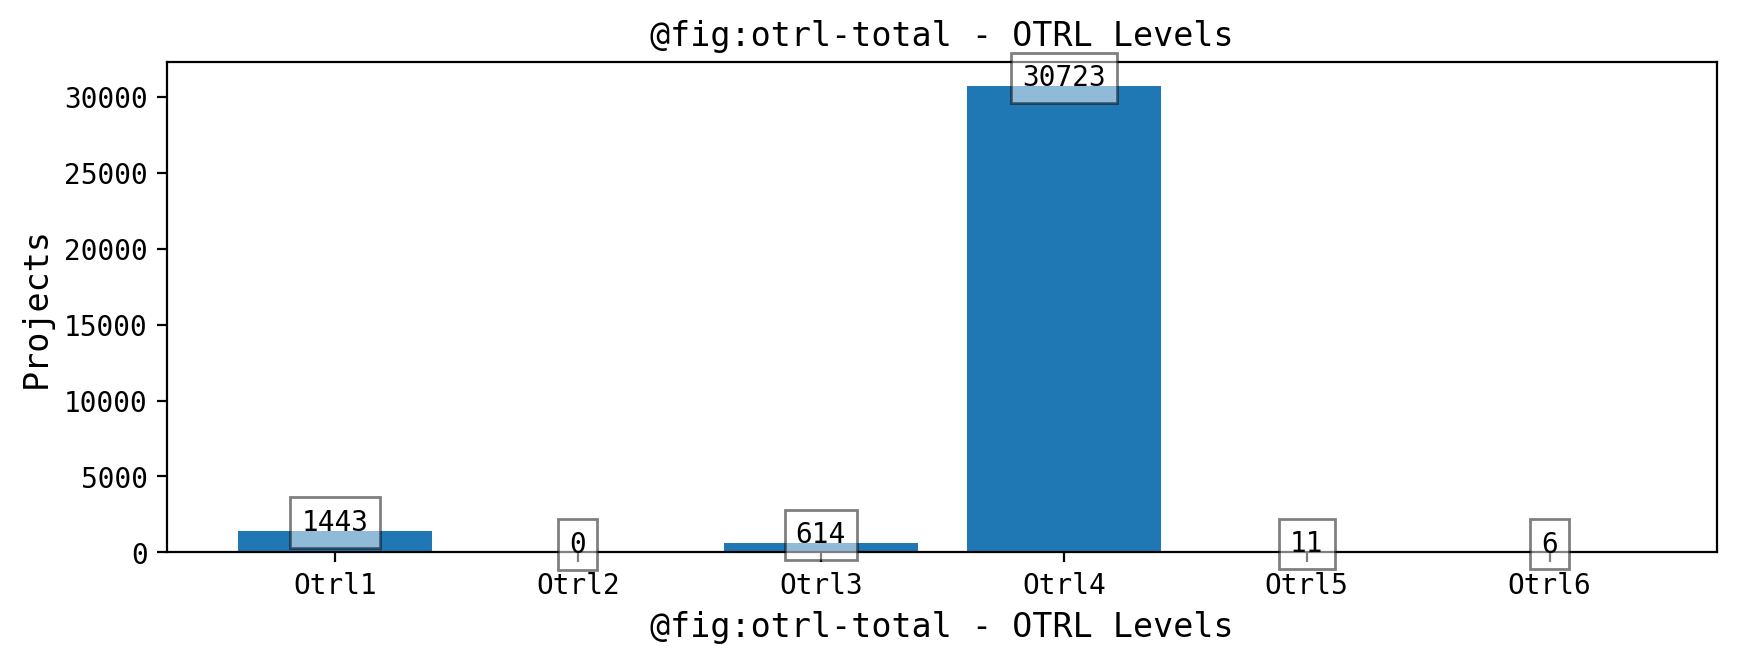

In [8]:
# horizontal stacked bar chart for OTRL levels and (stacked) their distribution among the {platforms}, also include "undefined"
x_selector="otrl.otrl"
y_selector="otrl.count"
otrl_all = ['Otrl1', 'Otrl2', 'Otrl3', 'Otrl4', 'Otrl5', 'Otrl6']
x, y = fetch_xy(x_selector, y_selector)

def fill_with_zero(x, y, all_x):
    tups = zip(x, y)
    tups = sorted(tups)
    non_zero_data = dict(tups)

    x = []
    y = []
    for i in range(len(all_x)):
        x.append(all_x[i])
        y.append(non_zero_data[all_x[i]] if all_x[i] in non_zero_data else 0)

    return x, y

x, y = fill_with_zero(x, y, otrl_all)

fig, ax = barchart_create(
    x, 
    y,
    title="@fig:otrl-total - OTRL Levels",
    label="Projects")
# ax.set_yscale('log')
barchart_add_labels(x, y)

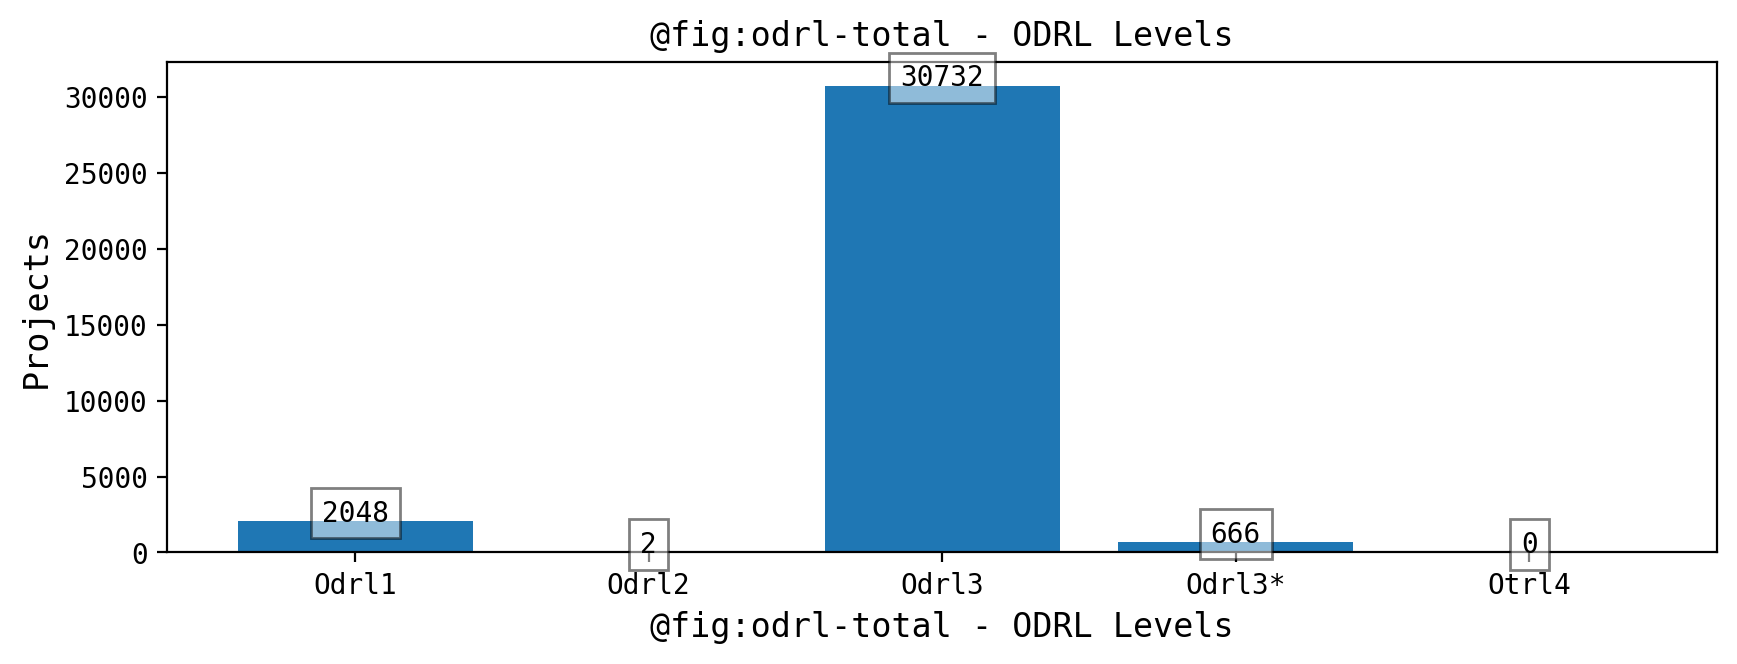

In [9]:
# horizontal stacked bar chart for ODRL levels and (stacked) their distribution among the {platforms}, also include "undefined
x_selector="odrl.odrl"
y_selector="odrl.count"
odrl_all = ['Odrl1', 'Odrl2', 'Odrl3', 'Odrl3*', 'Otrl4']
x, y = fetch_xy(x_selector, y_selector)
x, y = fill_with_zero(x, y, odrl_all)

fig, ax = barchart_create(
    x, 
    y,
    title="@fig:odrl-total - ODRL Levels",
    label="Projects")
# ax.set_yscale('log')
barchart_add_labels(x, y)

We can see in both charts very little scattering. Random samples have shown that the dominant blocks (OTRL-4 and ODRL3) mainly come from projects hosted at Thingiverse.com, which is by far providing the most OSH designs for the LOSH knowledge base (see figure @fig-repo-hosts above). Besides that, the combination OTRL-4 & ODRL-3, a working prototype with a stable documentation release, can be seen as typical for the OSH scene. An analysis of open source ventilators (created during the early COVID-19 pandemic) has come to similar results (see [here](https://doi.org/10.1016/j.procir.2022.05.306)).

The readiness levels are represented by the metadata fields `technology-readiness-level` and `documentation-readiness-level`, while `ODRL-3*` is generated when an entry for `attestation` is given.

<!-- @fig:otrl-odrl-heatmap shows the resulting heatmap for a combination of both scales. -->

In [10]:
# TODO Robin heatmap of all OSH projects with OTRL AND ODRL defined;
# see p. 5 here: https://docs.google.com/document/d/1-l6DI91unnAshzjKhjotpAfy_8RsS-9T7YmdYuwL4RI/edit#
# {#fig:otrl-odrl-heatmap}

### Technology Categories

In [11]:
# stacked bar charts with 1 bar per used first level CPC (F, H etc.) and the next sublevel (e.g. H03) stacked
# For human readability, we want to display the class and sub-class titles.
# We get them from the "CPC Title List" download found on this site:
# https://www.cooperativepatentclassification.org/cpcSchemeAndDefinitions/bulk
# Which at the time of our last download was:
# https://www.cooperativepatentclassification.org/sites/default/files/cpc/bulk/CPCTitleList202205.zip

num_cpc_projects = 0
cpc_mains = dict()
for cpc in result_data["cpc"]:
    main = cpc['cpc_main']
    sub = cpc['cpc_sub']
    count = cpc['count']
    num_cpc_projects += count
    cpc_mains.setdefault(main, {})[sub] = count
cpc_mains
#result_data["cpc"][0]['cpc_main']
#cpc_mains = set(x for result_data["cpc"])
# result_data["cpc"]


cpc_main_letters = [
    'A',
    'B',
    'C',
    'D',
    'E',
    'F',
    'G',
    'H',
    'Y'
]
cpc_main2index = { k: v for v, k in enumerate(cpc_main_letters) }

# A: Human Necessities
# B: Operations and Transport
# C: Chemistry and Metallurgy
# D: Textiles
# E: Fixed Constructions
# F: Mechanical Engineering
# G: Physics
# H: Electricity
# Y: Emerging Cross-Sectional Technologies
cpc_main_colors = [
    'pink', # A: Human Necessities
    'yellow',  # B: Operations and Transport
    'purple', # C: Chemistry and Metallurgy
    'red', # D: Textiles
    '#333333',  # E: Fixed Constructions
    'blue',  # F: Mechanical Engineering
    'green', # G: Physics
    'orange',  # H: Electricity
    '#AAAAAA'   # Y: Emerging Cross-Sectional Technologies
]

cpc_titles = dict()
with open('output/cpc-titles.csv', newline='') as cpc_titles_file:
    cpc_titles_list = csv.reader(cpc_titles_file)
    for cpc_title in cpc_titles_list:
        cpc_titles[cpc_title[0]] = cpc_title[1]
        # print(', '.join(cpc_title))


Classifying hardware by it's technology can be a non-trivial task – every online platform seems to run their own from-scratch-developed category system. For instance the [OSHWA certification program](https://certification.oshwa.org/list.html) uses a system that includes categories like "IOT" or "Robotics" but also "Art", "3D Printing" and "Environmental" – it mixes different domains (technical features, used manfacturing technology, operational environment) and doesn't connect well to other systems with, again, a category system specialized for the sole use on that platform (as e.g. thingiverse which useses tags like "coronavirus" and "youtube").

LOSH tries to merge some of those category system into a single, established one that has been around for a while: patent classes, specifically the [Cooperative Patent Classification](https://www.epo.org/searching-for-patents/helpful-resources/first-time-here/classification/cpc.html) system (CPC). This may even help patent agents when searching for relevant open source designs (#defensive-publishing).

Here, every individual approach for a category system requires an own mapping. E.g. for the OSHWA category system the mapping can be found [here](https://github.com/OPEN-NEXT/OKH-LOSH/blob/master/data_mapping/data-mapping-OSHWA.md#category-mapping). However, some categories can (at most) only be matched on the very first levels of the CPC classification (e.g. OSHWA's "IOT" equals the CPC's "H04" class).

In [12]:
md("""However, since LOSH can only process data that is provided in the first place,
  detailled patent classes are at the moment only available for """
   + str(num_cpc_projects)
   + """ OSH projects (that is """
   + str(round(num_cpc_projects * 100.0 / num_all_projects, 2))
   + """ % of the knowledge base).
   For these projects rich metadata has been manually curated during the [OPEN_NEXT project](https://opennext.eu/);
   the automated category mapping was yet too buggy for the productive deployment.
   @fig:cpc-total shows the total distribution of top-level CPCs, 
   @tbl:cpc-legend provides the full designation for those IDs.""")

However, since LOSH can only process data that is provided in the first place,
  detailled patent classes are at the moment only available for 64 OSH projects (that is 0.19 % of the knowledge base).
   For these projects rich metadata has been manually curated during the [OPEN_NEXT project](https://opennext.eu/);
   the automated category mapping was yet too buggy for the productive deployment.
   @fig:cpc-total shows the total distribution of top-level CPCs, 
   @tbl:cpc-legend provides the full designation for those IDs.

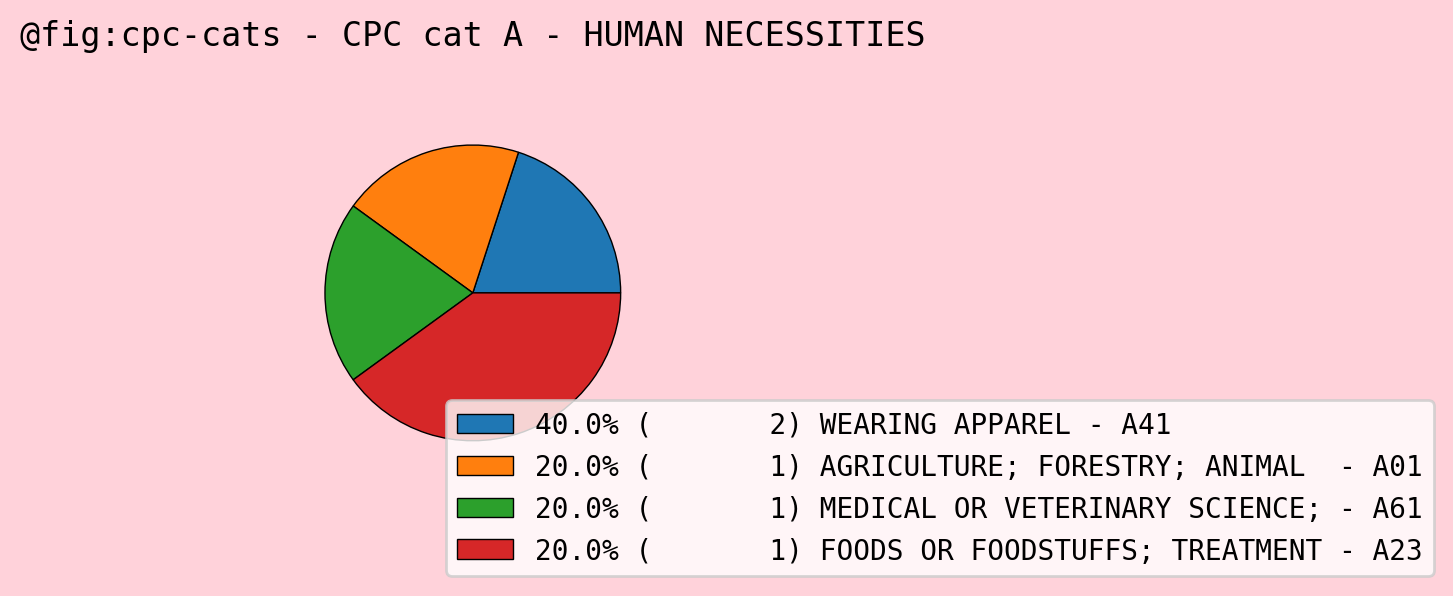

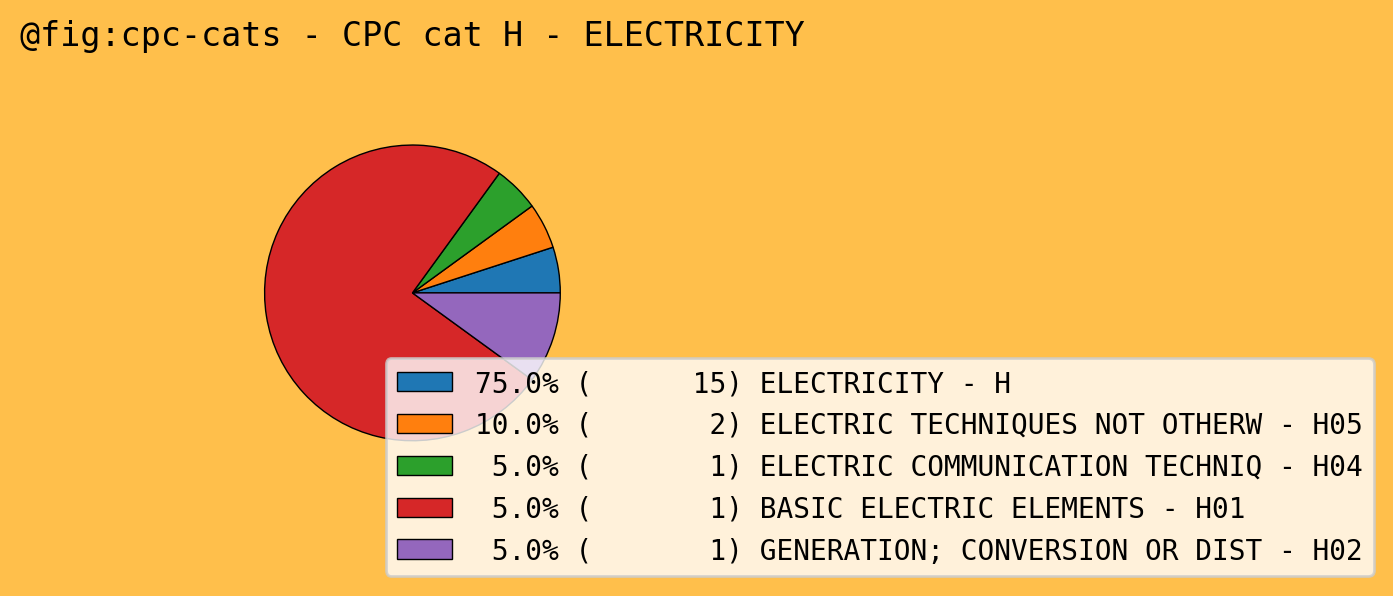

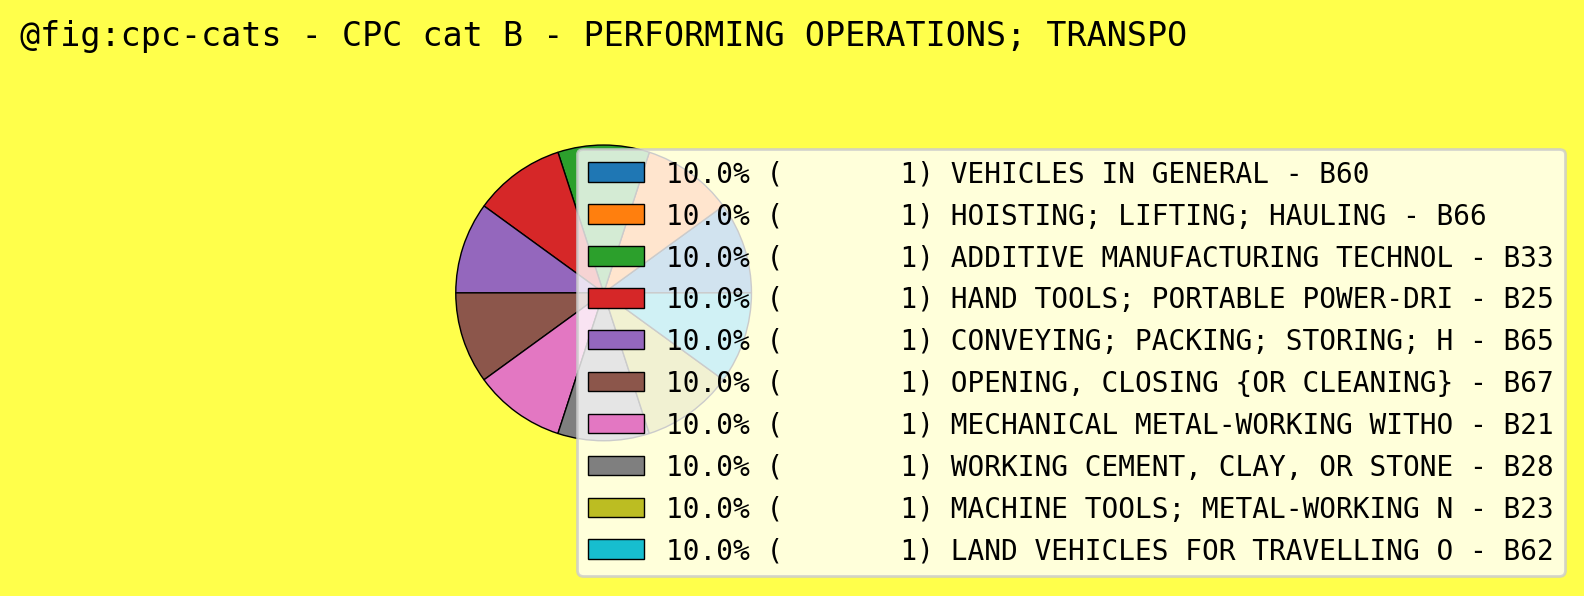

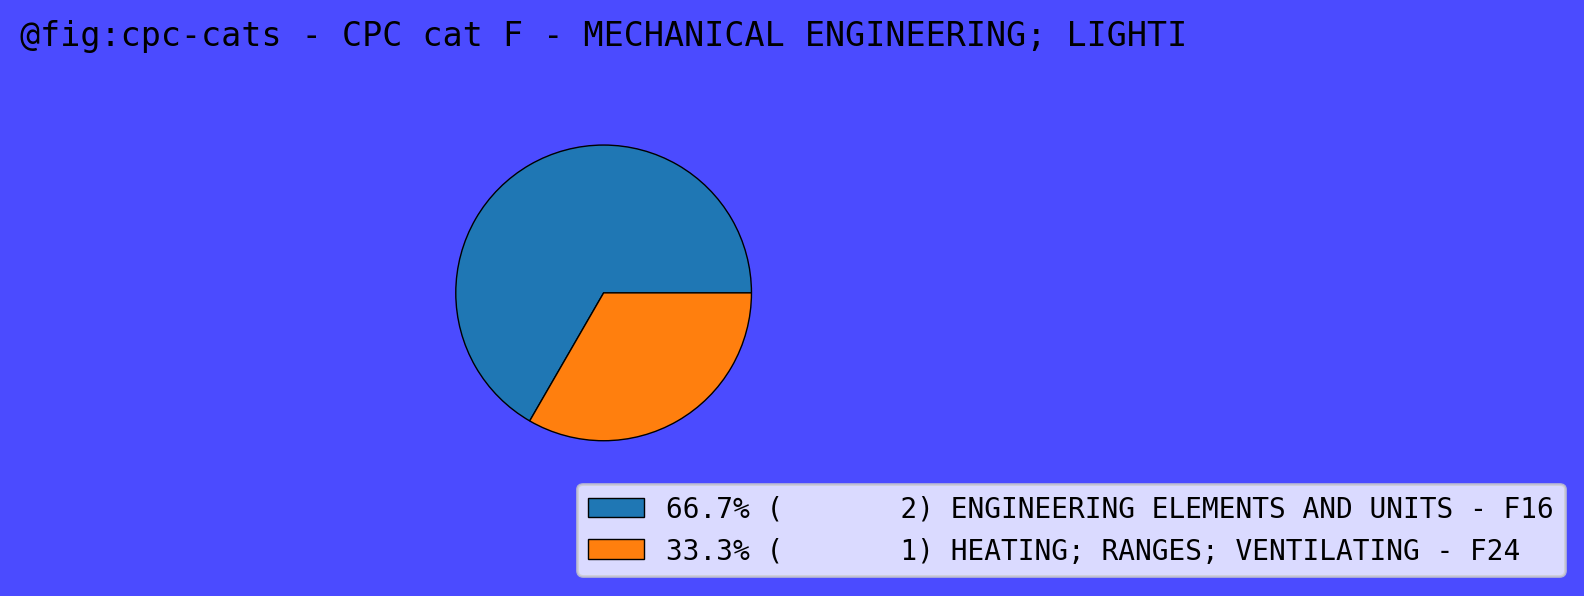

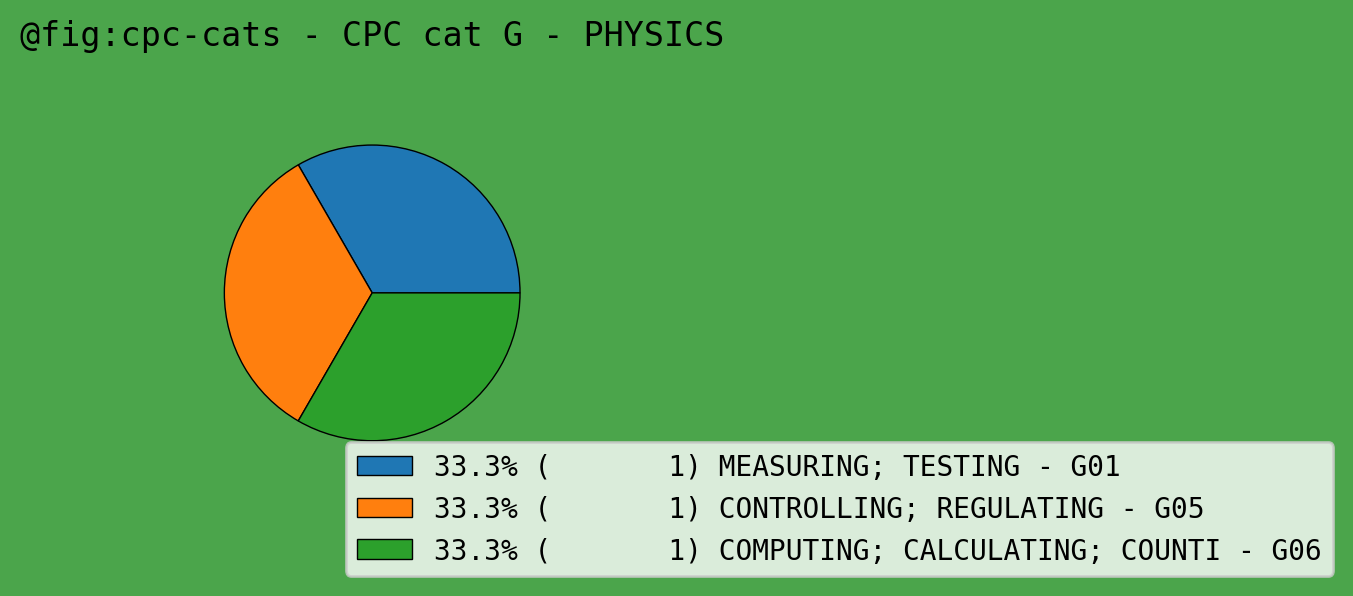

In [13]:
for main in cpc_mains:
    subs = cpc_mains[main]
    x = [ cpc_titles[main + k][:30] + ' - ' + main + re.sub(r'^$', '  ', k) for k in subs.keys() ]
    if len(x) < 2:
        continue
    y = list(subs.values())
    fig_cpcs, ax_cpcs = piechart_create(
        x,
        y,
        title="@fig:cpc-cats - CPC cat " + main + " - " + cpc_titles[main][:30],
        label="Projects",
        legend_vals=True)
    fig_cpcs.patch.set_facecolor(cpc_main_colors[cpc_main2index[main]])
    fig_cpcs.patch.set_alpha(0.7)

In [14]:
labels = []
ids = []
titles = []
values = []
colors = []
for main in cpc_mains:
    subs = cpc_mains[main]
    # ax.bar(cpc_main_keys, vals, width)
    ids += [ main + k for k in subs.keys() ]
    titles += [ cpc_titles[main + k] for k in subs.keys() ]
    labels += [ cpc_titles[main + k][:30] + ' - ' + main + re.sub(r'^$', '  ', k) for k in subs.keys() ]
    # cpc_titles
    values += subs.values()
    colors += [cpc_main_colors[cpc_main2index[main]]] * len(subs)

# y_pos = range(len(values))
# plt.rcdefaults()
# fig, ax = plt.subplots()
# ax.barh(y_pos, values, align='center', color=colors)
# ax.set_yticks(y_pos, labels=labels)
# ax.invert_yaxis() # labels read top-to-bottom
# ax.set_xlabel('Projects')
# ax.set_title('@fig:cpc-sub-cats - CPC sub-categories')
# plt.show()

md_table = """
`@tbl:cpc-legend`

| CPC ID | #Projects | Title |
| --- | --- | --- |
| CPC ID | #Projects | Title |
"""
for i in range(len(values)):
    md_table += "| " + ids[i] + " | " + str(values[i]) + " | " + titles[i] + " |\n"
md(md_table)


`@tbl:cpc-legend`

| CPC ID | #Projects | Title |
| --- | --- | --- |
| CPC ID | #Projects | Title |
| A01 | 1 | AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTING; TRAPPING; FISHING |
| A61 | 1 | MEDICAL OR VETERINARY SCIENCE; HYGIENE |
| A23 | 1 | FOODS OR FOODSTUFFS; TREATMENT THEREOF, NOT COVERED BY OTHER CLASSES |
| A41 | 2 | WEARING APPAREL |
| H04 | 1 | ELECTRIC COMMUNICATION TECHNIQUE |
| H01 | 1 | BASIC ELECTRIC ELEMENTS |
| H02 | 1 | GENERATION; CONVERSION OR DISTRIBUTION OF ELECTRIC POWER |
| H | 15 | ELECTRICITY |
| H05 | 2 | ELECTRIC TECHNIQUES NOT OTHERWISE PROVIDED FOR |
| B60 | 1 | VEHICLES IN GENERAL |
| B66 | 1 | HOISTING; LIFTING; HAULING |
| B33 | 1 | ADDITIVE MANUFACTURING TECHNOLOGY |
| B25 | 1 | HAND TOOLS; PORTABLE POWER-DRIVEN TOOLS; MANIPULATORS |
| B65 | 1 | CONVEYING; PACKING; STORING; HANDLING THIN OR FILAMENTARY MATERIAL |
| B67 | 1 | OPENING, CLOSING {OR CLEANING} BOTTLES, JARS OR SIMILAR CONTAINERS; LIQUID HANDLING |
| B21 | 1 | MECHANICAL METAL-WORKING WITHOUT ESSENTIALLY REMOVING MATERIAL; PUNCHING METAL |
| B28 | 1 | WORKING CEMENT, CLAY, OR STONE |
| B23 | 1 | MACHINE TOOLS; METAL-WORKING NOT OTHERWISE PROVIDED FOR |
| B62 | 1 | LAND VEHICLES FOR TRAVELLING OTHERWISE THAN ON RAILS |
| F16 | 2 | ENGINEERING ELEMENTS AND UNITS; GENERAL MEASURES FOR PRODUCING AND MAINTAINING EFFECTIVE FUNCTIONING OF MACHINES OR INSTALLATIONS; THERMAL INSULATION IN GENERAL |
| F24 | 1 | HEATING; RANGES; VENTILATING |
| G01 | 1 | MEASURING; TESTING |
| G05 | 1 | CONTROLLING; REGULATING |
| G06 | 1 | COMPUTING; CALCULATING; COUNTING |
| C12 | 1 | BIOCHEMISTRY; BEER; SPIRITS; WINE; VINEGAR; MICROBIOLOGY; ENZYMOLOGY; MUTATION OR GENETIC ENGINEERING |
| D03 | 3 | WEAVING |
| Y02 | 1 | TECHNOLOGIES OR APPLICATIONS FOR MITIGATION OR ADAPTATION AGAINST CLIMATE CHANGE |


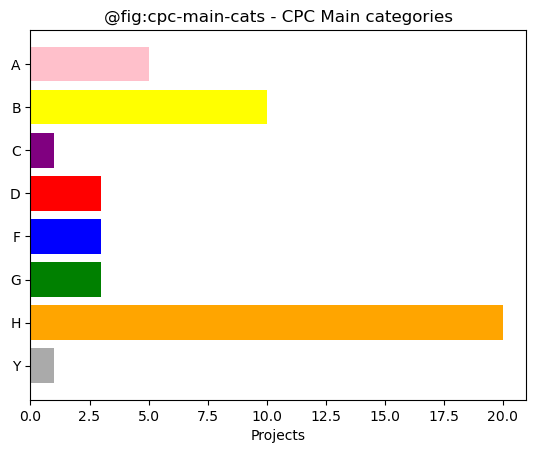

In [15]:
main_labels = list(cpc_mains.keys())
main_labels.sort()
main_colors = [ cpc_main_colors[cpc_main2index[main]] for main in main_labels ]
main_projs = [ sum(cpc_mains[main].values()) for main in main_labels ]

y_pos = range(len(main_labels))
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, main_projs, align='center', color=main_colors)
ax.set_yticks(y_pos, labels=main_labels)
ax.invert_yaxis() # labels read top-to-bottom
ax.set_xlabel('Projects')
ax.set_title('@fig:cpc-main-cats - CPC Main categories')
plt.show()

The data is represented by the metadata field `cpc-patent-class`.

The figures show that, even through the small sample of OSH designs, all 8 CPC sections are covered in the LOSH knowledge base, while electrical/electronical designs feature the dominant part. Unfortunately the data doesn't allow for a deeper analysis of the technological distribution of OSH designs; many categories are represented by very few OSH designs and the current results are heavily influenced by the manual curated dataset mentioned above.

# Highlighted projects

We'd like to take the opportunity to highlight a few selected OSH projects. For this first version of the LOSH report we asked the OPEN!NEXT and the OSEG community which projects they would like to see highlighted. We condensed the suggestions to a list of their top 3 choices: we featured them as "flagships", providing a reference for what OSH can be in in practice. 

If you want to see a specific OSH project highlighted here, feel free to submit your suggestion to [rm@oho.wiki](mailto:rm@oho.wiki?cc=mh@oho.wiki&subject=OSH%20highlight%20for%20next%20LOSH%20report), so we can consider it for our next edition of the report.

## The ultimate open source laptop

![MNT Reform](output/imgs/reform_v2_prototype_top.jpg)

[MNT Reform](https://mntre.com/media/reform_md/2020-05-08-the-much-more-personal-computer.html) is an open source hardware laptop, designed and assembled in Berlin. We found that it features the first laptop that is 1) usable as an actual workstation and 2) as open source as possible. Any component in this laptop can be replaced; the product gets shiped with printed circuit diagrams. They even developed some KiCAD modules themselves to make their hardware development possible with a FOSS tool chain. The hardware is licensed under [CERN-OHL-S-2.0](https://source.mnt.re/reform/reform/-/raw/master/LICENSES/CERN-OHL-S%20v2.txt), firmware and related software under [GPL-3.0-or-later](https://source.mnt.re/reform/reform/-/raw/master/LICENSES/GPLv3.md). Find the source under <https://source.mnt.re/reform/reform/>. There's also a noteable fork of the design [here](https://community.mnt.re/t/im-building-my-own-reform/759).

The MNT Reform notebook is OSHWA-certified and has been attested in a community-based process according to DIN SPEC 3105-2. It is included in the LOSH database, you can find it [here](https://losh.opennext.eu/detail/Q848666).

## A 3D-printable microscope

![OpenFlexure v1.2.0](output/imgs/ds_v1.2.0_wide.jpg)

[OpenFlexure](https://openflexure.org/) is a low-cost remote controllable microscope that allows for sub-100 nm fibre alignment with a monolithic plastic flexure stage ([reference](https://doi.org/10.1364/OE.384207)). To make this possible, the motion control relies on bending rather than moving parts. Apart from being an impressive piece of engineering it is also one of the first OSH projects to get officially community-assessed according to DIN SPEC 3105-2 by OSEG's confirmity assessment body (see below) – and it has been found to provide one of the best documentations these folks (and our team) have seen in a while (their GitLab repository even performs automated collision tests of parts during development). The microscope comes in a low-cost and a high-performance variant. To make OSH documentation possible (and relatively effortless) at this scale, they even developed their own documentation tool: [GitBuilding](https://gitbuilding.io/) ([GPL-3.0-or-later](https://gitlab.com/gitbuilding/gitbuilding/-/raw/master/LICENSE)). Hardware and software source files are available under <https://gitlab.com/openflexure> (e.g. the delta stage is licensed under [CERN-OHL-1.2](https://gitlab.com/openflexure/openflexure-delta-stage/-/raw/master/LICENSE)). Most of the [core development team](https://openflexure.org/about/people/) are based at the [University of Bath](https://www.bath.ac.uk/) (yes, where the [RepRap](https://reprap.org/) comes from) and the [University of Cambridge](https://www.cam.ac.uk/).

Since the documentation is entirely on GitLab, it is in principle not included in the LOSH dataset (see the [Limitations](#Limitations) section below). However, the maintainers have published a duplicate of a part of the technical documentation on Wikifactory, which in turn _is_ included in the LOSH dataset (find it [here](https://losh.opennext.eu/detail/Q7051)).

## Open source satellites in space

![upsat in space](output/imgs/Upsatinspace.jpg)

[UPSat](https://upsat.gr/) is the first satellite made entirely of open source soft- and hardware. It was a project of the [University of Patras](https://www.upatras.gr/en/) and the [Libre Space Foundation](https://libre.space/) – and indeed launched into space! UPSat left Cape Canaveral (Florida) at April 18, 2017 11:11 EDT to reach the International Space Station (ISS). From there it got released in orbit, see a picture minutes after its deployment above. All data and telemetry that was sent from UPSat is publicly available. However, UPSat decayed at November 13, 2018. Hardware and software source files are available under <https://gitlab.com/librespacefoundation/upsat> (e.g. the frame structure is licensed under [CERN-OHL-1.2](https://gitlab.com/librespacefoundation/upsat/upsat-structural/-/raw/master/LICENSE)). The hardware was mainly built and tested in [Hackerspace.gr](https://www.hackerspace.gr/), a hackerspace that aims to provide a 24/7 open space for open source folks and their projects in Athens (Greece).

Since the documentation is entirely on GitLab, it is in principle not included in the LOSH dataset (see the [Limitations](#Limitations) section below).

## Community-based assessment of OSH

Not an actual OSH project, but here to raise the documentation quality of OSH and provide a trustful assessment procedure e.g. for funding bodies.

[DIN SPEC 3105](https://journalopenhw.medium.com/din-spec-3105-explained-2cce6134c207) is an official standard published under a free/open license ([CC-BY-SA-4.0](https://gitlab.com/OSEGermany/OHS-3105/-/raw/ohs/LICENSE.md)) defining:

- requirements that qualify hardware as "open source hardware" and
- a community-based assessment process to validate that a given version of a project meets these criteria.

In 2021 two OSH organizations have launched a so-called "confirmity assessment body according to DIN SPEC 3105-2" and hence can act as an independent, community-based authority to verify the licensing scheme and documentation quality of OSH projects. For more information please refer to the organizations directly:

- [OHO Certification Center](https://en.oho.wiki/wiki/About_the_OHO_Certification-center) by [Open Hardware Observatory e.V.](https://en.oho.wiki/wiki/Home) (non-profit);
- [OSEG-CAB](https://gitlab.opensourceecology.de/verein/projekte/cab/CAB) by [Open Source Ecology Germany e.V.](https://ose-germany.de/) (non-profit).


# Limitations

As mentioned in the introduction at the beginning of this report, the LOSH Reporter is an open source project that was initiated by the research project [OPEN_NEXT](https://opennext.eu/). However, it's far from finished. There is a bunch of known issues and limitations and you (yes, _you_) can help us to improve this report and the software tools behind it. Just reach out to the contacts named above or visit our GitHub repository directly and tell us, how we can make this report better (e.g. by pointing out issues you found) – or collaborate directly with us and join the development forces.

GitHub repository: <https://github.com/OPEN-NEXT/LOSH-Reporter/>

Known limitations in this report:

- no historical data available
  - the solution would require changes of the crawler, which gets the data in the first place
- no location data available
  - some platforms do provide this data, but the solution would require changes of the crawler
- no platform-specific metadata available
  - also this would require changes of the crawler
- no data about multiple licenses in a repository
  - some projects may use different licenses for certain parts in their technical documentation or license their CAD files differently or include software, meant to run on the piece of hardware, in the same repository, with a specific software license
  - currently the crawler can only get one license; if multiple licenses are found (as on the OSHWA certification list), only the hardware license is considered; to fix this, the crawler needs to be adjusted
- no projects from GitLab available
  - currently, GitLab's API doesn't provide enough features for effective crawling – at least using the tools we have at the moment

You see, limitations are mainly rooted in a lack of data, no in the report itself. The crawler is an independent software module within the LOSH ecosystem and developed here: <https://github.com/OPEN-NEXT/LOSH-krawler> .

# Outro

We hope you have enjoyed readings this report and maybe even found a few things valuable for your own projects. Besides that we believe, you might have tons of suggestions how to improve this report, since it is the first one we publish. If you want to support our work, please reach out to [rm@oho.wiki](mailto:rm@oho.wiki?cc=mh@oho.wiki&subject=CONTRIBUTE%20to%20LOSH%20reports).

We also want to point out that we observe lots of (good) motion in the field of OSH and that we are not the only report on the state of OSH. See for instance the annual report from our friends from OSHWA under <https://stateofoshw.oshwa.org/>.

A big THANK YOU to all the human beings out there contributing to our global ecosystem of open source technologies. Keep it up.